In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Image Preprocessing

In [42]:
image = Image.open("./assets/composition-VII.jpeg")

composed_transformation = transforms.Compose([
    # 224 is the input size for VGG (later)
    transforms.Resize( (224, 224) ),
    transforms.ToTensor()
])

In [87]:
def preprocess_image(image: Image) -> torch.Tensor:
    """
    Given a PIL image, resizes it and converts it to a torch tensor

    Args:
        image (Image): PIL image

    Returns:
        Tensor of dim (#channels, height, width)
    """
    composed_image: torch.Tensor = composed_transformation(image)

    # Change from channel first to channel last
    # return composed_image.permute(1, 2, 0)
    return composed_image

(-0.5, 223.5, 223.5, -0.5)

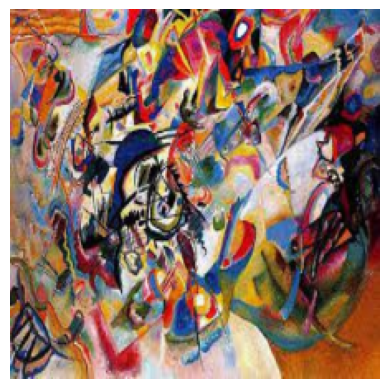

In [90]:
proccessed_image = preprocess_image(image)

# Adjust image dim to be compatible with plt
# (#c, h, w) -> (h, w, #c) 
plt.imshow(proccessed_image.permute(1, 2, 0))
plt.axis('off')

#### CNN model (VGG)

In [91]:
vgg_model: torchvision.models.VGG = torchvision.models.vgg19_bn()

In [92]:
# Extract the convolutional layers
conv_layers = []

for layer in vgg_model.features:
    if isinstance(layer, torch.nn.Conv2d):
        conv_layers.append(layer)

len(conv_layers)

16

#### Content Loss Function
We can define the **feature map** of an image by $F^l_{ij}$ with $i$ and $j$ denoting the $i^{th}$ filter at position $j$ in layer $l$.

* In particular, the loss function is defined by the MSE between 
    - the feature map of the original image, $\vec{p}$, denoted by $P^l$ and 
    - the feature map of the generated image, $\vec{x}$, denoted by $F^l$

$$\mathcal{L}(\vec{p},\:\vec{x},\:l)=\frac{1}{2}\sum_{i,\:j}(F^l_{ij} -P^l_{ij})^2$$

In [94]:
def get_feature_map(image: torch.Tensor, layer: torch.nn.Conv2d) -> torch.Tensor:
    """
    Given an image and a convolutional layer, returns the feature map
    of the image after passing through the layer

    Done using Pytorch hooks:
    https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

    Args:
        image (Tensor): Image of dim (height, width, #channels)
        layer (torch.nn.Conv2d): Convolutional layer

    Returns:
        Tensor of dim (height, width, #channels)
    """
    # Add a dimension to the image to make it (1, height, width, #channels)
    image = image.unsqueeze(0)

    activation = None
    
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output.detach()

    hook = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        image_tensor = image.to(device)
        vgg_model(image_tensor)

    hook.remove()

    return activation.squeeze()

In [95]:
def get_content_loss(
    content_image: torch.Tensor,
    generated_image: torch.Tensor,
    layer: torch.nn.Conv2d
) -> torch.Tensor:
    """
    Computes the content loss

    Args:
        content_image (Tensor): Content image
        generated_image (Tensor): Generated image
        layer (torch.nn.Conv2d): Convolutional layer

    Returns:
        Tensor: Content loss
    """
    p_l = get_feature_map(content_image, layer)
    f_l = get_feature_map(generated_image, layer)

    content_loss = torch.nn.MSELoss()
    return content_loss(p_l, f_l)